# Spatial Transformer Network with IDSIA-like convolutional neural network for German Traffic Signs Dataset classification

In [1]:
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import random
import cv2

from tqdm import tqdm_notebook as tqdm
from skimage import exposure, transform, color
import os
import multiprocessing

from sklearn.utils import shuffle
from copy import deepcopy

from scipy.stats import spearmanr
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random

In [2]:
data_path = 'GTSRB/Final_Training/Images/'
test_path = 'GTSRB/Final_Test/Images/'

In [3]:
def preprocess_image(img):
    img = cv2.resize(img, (32,32))
    img = exposure.equalize_adapthist(img, nbins=256)
    img = exposure.equalize_hist(img, 256)
    return img

In [4]:
def OneHotEncoder(label, n_classes):
    oneHot = np.zeros(n_classes, dtype='int32')
    temp = oneHot.copy()
    temp[label] = 1
    return temp

In [5]:
def batch_generator(X, y, batch_size):
    X_aug, y_aug = shuffle(X, y)
    
    for offset in range(0, X_aug.shape[0], batch_size):
        end = offset + batch_size
        batch_x, batch_y = X_aug[offset:end,...], y_aug[offset:end]
        
        yield batch_x, batch_y

## Training and Validation Set

In [6]:
X_train = []
y_train = []
X_val = []
y_val = []
n_classes = 43

for folder in tqdm(os.listdir(data_path)):
    for file in os.listdir(data_path+folder)[:int(0.9*len(os.listdir(data_path+folder)))]:
        if file.split('.')[-1] == 'ppm':
            X_train.append(np.expand_dims(preprocess_image(cv2.imread(data_path+folder+'/'+file, 0)), axis=-1))
            y_train.append(OneHotEncoder(int(folder[-2:]), n_classes))
    for file in os.listdir(data_path+folder)[int(0.9*len(os.listdir(data_path+folder))):]:
        if file.split('.')[-1] == 'ppm':
            X_val.append(np.expand_dims(preprocess_image(cv2.imread(data_path+folder+'/'+file, 0)), axis=-1))
            y_val.append(OneHotEncoder(int(folder[-2:]), n_classes))

## Test Set

In [7]:
X_test = []
for image in tqdm(os.listdir(test_path)):
    if image.split('.')[-1] == 'ppm':
        X_test.append(np.expand_dims(preprocess_image(cv2.imread(test_path+image, 0)), axis=-1))

In [8]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

## EDA on the Dataset

### Totals

In [9]:
labels = pd.read_csv('signnames.csv')['SignName']

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_val)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 35250
Number of validation examples = 3959
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


### Let's visualize things!

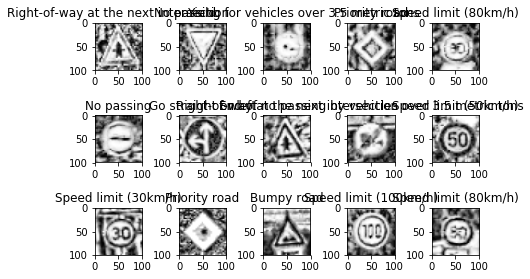

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=5)
fig.tight_layout()
for splot in range(1,16):
    idx = random.randint(0,35250)
    plt.subplot(3,5,splot)
    plt.title(labels[y_train[idx].argmax()])
    plt.imshow(cv2.resize(X_train[idx], (100, 100)), cmap='Greys_r')

## Collect and Store Results

In [11]:
X_train.shape

(35250, 32, 32, 1)

# CNN Training with TensorFlow

In [12]:
import tensorflow as tf

from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import batch_norm
from spatial_transformer import transformer
from tf_utils import weight_variable, bias_variable, dense_to_one_hot

# Resetting DAG to avoid collisions with previously initialized graph
# This is extremely important because TF caches variables and outputs VERY weird results/scores in case you
# forget this clean up.

tf.reset_default_graph()

TF_CONFIG = {
    'epochs': 10,
    'batch_size': 256,
    'channels': 1
}

BATCH_SIZE = 256

### Generic operations for TensorFlow

In [13]:
### Conv layers ops

def convolution_relu(batch_x, kernel_shape, bias_shape, strides=1):
    w_conv = tf.get_variable("w_conv", shape=kernel_shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())
    b_conv = tf.get_variable("b_conv", shape=bias_shape, initializer=tf.constant_initializer(0.0))
    
    convolution = tf.nn.conv2d(batch_x, w_conv, strides=[1, strides, strides, 1], padding='SAME')
    convolution = tf.add(convolution, b_conv)
    return tf.nn.relu(convolution)

def convolution_relu_batchnorm(batch_x, kernel_shape, bias_shape, strides=1):
    activation = convolution_relu(batch_x, kernel_shape, bias_shape)
    return batch_norm(activation)

def maxpooling(batch_x, k=2):
    return tf.nn.max_pool(batch_x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')

### Generic fully-connected ops

def fc_matmul_logits(batch_x, weights_shape, bias_shape):
    w_fc = tf.get_variable("w_fc", shape=weights_shape, initializer=tf.contrib.layers.xavier_initializer())
    b_fc = tf.get_variable("b_fc", shape=bias_shape, initializer=tf.constant_initializer(0.0))

    linear_transform = tf.add(tf.matmul(batch_x, w_fc), b_fc)
    return linear_transform

def fc_matmul_relu(batch_x, weights_shape, bias_shape):
    linear_transform = fc_matmul_logits(batch_x, weights_shape, bias_shape)
    return tf.nn.relu(linear_transform)

def fc_matmul_relu_dropout(batch_x, weights_shape, bias_shape, dropout_keep):
    return tf.nn.dropout(fc_matmul_relu(batch_x, weights_shape, bias_shape), dropout_keep)

### Composite fully-connected ops

def fc_batchnorm_matmul_logits(batch_x, weights_shape, bias_shape):   
    batch_x_norm = batch_norm(batch_x)
    return fc_matmul_logits(batch_x_norm, weights_shape, bias_shape)

def fc_batchnorm_matmul_relu(batch_x, weights_shape, bias_shape):
    batch_x_norm = batch_norm(batch_x)
    return fc_matmul_relu(batch_x_norm, weights_shape, bias_shape)

def fc_batchnorm_matmul_relu_dropout(batch_x, weights_shape, bias_shape, dropout_keep):
    activation = fc_batchnorm_matmul_relu(batch_x, weights_shape, bias_shape)
    return tf.nn.dropout(activation, dropout_keep)

## Spatial Transformer Network

### Convolutional part of localization network

In [14]:
def stn_convolve_pool_flatten_type2(batch_x):
    kernels = {
        'conv1': [5, 5, TF_CONFIG['channels'], 100],
        'conv2': [5, 5, 100, 200],
    }
    biases = {
        'conv1': [100],
        'conv2': [200],
    }
    
    with tf.variable_scope('stn_conv1'):
        pooled_batch_x = maxpooling(batch_x, k=2)
        # Layer 1 and 2: Convolution -> Activation 
        activation1 = convolution_relu_batchnorm(pooled_batch_x, kernels['conv1'], biases['conv1'])
        
        # Layer 3: Max Pooling
        pool1 = maxpooling(activation1, k=2)
        
    with tf.variable_scope('stn_conv2'):
        # Layer 4 and 5: Convolution -> Activation
        activation2 = convolution_relu_batchnorm(pool1, kernels['conv2'], biases['conv2'])
        
        # Layer 6: Max Pooling
        pool2 = maxpooling(activation2, k=2)


    # Layer 9: Flatten
        pool1 = maxpooling(pool1, k=4)
        pool2 = maxpooling(pool2, k=2)

        flat_features = tf.concat([flatten(pool1), flatten(pool2)], 1)
        
        return flat_features

### Fully-connected part of localization network

In [15]:
def stn_locnet_type2(flat_features):
    weights = {
        'fc1': [1200, 100],
        'out': [100, 6]
    }
    
    biases = {
        'fc1': [100],
        'out': [6]
    }
    with tf.variable_scope('locnet_fc1'):       
        W_fc1 = tf.Variable(tf.zeros([1200, 100]), name='sp_weight_fc1')
        b_fc1 = tf.Variable(tf.zeros([100]), name='sp_biases_fc1')

        sp_fc1 = batch_norm(flat_features)
        sp_fc1 = tf.add(tf.matmul(sp_fc1, W_fc1), b_fc1)
        sp_fc1 = tf.nn.relu(sp_fc1)
        sp_fc1 = tf.nn.dropout(sp_fc1, dropout_loc)

    with tf.variable_scope('locnet_fc2'):
        initial = np.array([[1.0, 0, 0], [0, 1.0, 0]])
        initial = initial.astype('float32')
        initial = initial.flatten()

        W_fc2 = tf.Variable(tf.zeros([100, 6]), name='sp_weight_fc2')
        b_fc2 = tf.Variable(initial_value=initial, name='sp_biases_fc2')
        
        sp_fc2 = batch_norm(sp_fc1)
        sp_fc2 = tf.add(tf.matmul(sp_fc2, W_fc2), b_fc2)

        return sp_fc2

### Main network: IDSIA

### Part 1 — Convolutional Layers

In [16]:
def idsia_convolve_pool_flatten(batch_x, multiscale=True):
    # Input: batch_size * 32 * 32 * 1 images
    # Multiscale uses features from both conv layers
    
    kernels = {
        'conv1': [7, 7, TF_CONFIG['channels'], 100],
        'conv2': [4, 4, 100, 150],
        'conv3': [4, 4, 150, 250]
    }
    biases = {
        'conv1': [100],
        'conv2': [150],
        'conv3': [250]
    }
    
    with tf.variable_scope('conv1'):
        # Layer 1 and 2: Convolution -> Activation 
        activation1 = convolution_relu(batch_x, kernel_shape=kernels['conv1'], bias_shape=biases['conv1'])
        
        # Layer 3: Max Pooling
        pool1 = maxpooling(activation1, k=2)
        
    with tf.variable_scope('conv2'):
        # Layer 4 and 5: Convolution -> Activation
        activation2 = convolution_relu(pool1, kernel_shape=kernels['conv2'], bias_shape=biases['conv2'])
        
        # Layer 6: Max Pooling
        pool2 = maxpooling(activation2, k=2)

    with tf.variable_scope('conv3'):
        # Layer 7 and 8: Convolution -> Activation
        activation3 = convolution_relu(pool2, kernel_shape=kernels['conv3'], bias_shape=biases['conv3'])
        pool3 = maxpooling(activation3, k=2)
                
    # Layer 9: Flatten
    pool1 = maxpooling(pool1, k=8)
    pool2 = maxpooling(pool2, k=4)
    pool3 = maxpooling(pool3, k=2)
    
    if multiscale is True:
        flat_features = tf.concat([flatten(pool1), flatten(pool2), flatten(pool3)], 1)
    else:
        flat_features = flatten(activation3)

    return flat_features, activation1

### Part 2 — Fully connected layers

In [17]:
def idsia_fc_logits(batch_x, multiscale=True):
    weights = {
        'fc1': [3200, 100],
        'fc1_multi': [2000, 300],
        'out': [300, n_classes]
    }
    
    biases = {
        'fc1': [300],
        'out': [n_classes]
    }
    
    with tf.variable_scope('fc1'):
        if multiscale is True:
            activation1 = fc_batchnorm_matmul_relu_dropout(batch_x, weights['fc1_multi'], biases['fc1'], dropout_keep=dropout_fc1)
        else:
            activation1 = fc_batchnorm_matmul_relu_dropout(batch_x, weights['fc1'], bias_shape=biases['fc1'], dropout_keep=dropout_fc1)
        
    with tf.variable_scope('out'):
        logits = fc_batchnorm_matmul_logits(activation1, weights['out'], biases['out'])
    
    return logits

### Part 3 — Building the network: inference

In [18]:
def stn_idsia_inference_type2(batch_x):
    with tf.name_scope('stn_network_t2'):
        stn_output = stn_locnet_type2(stn_convolve_pool_flatten_type2(batch_x))
        transformed_batch_x = transformer(batch_x, stn_output, (32, 32, TF_CONFIG['channels']))

    with tf.name_scope('idsia_classifier'):
        features, batch_act = idsia_convolve_pool_flatten(transformed_batch_x, multiscale=True)
        logits = idsia_fc_logits(features, multiscale=True)

    return logits, transformed_batch_x, batch_act

### Part 4 — Metrics, parameters and network initialization

In [19]:
def calculate_loss(logits, y):
    with tf.name_scope('Predictions'):
        predictions = tf.nn.softmax(logits)
    with tf.name_scope('Model'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    with tf.name_scope('Loss'):
        loss_operation = tf.reduce_mean(cross_entropy)
    return loss_operation


boundaries = [100, 250, 500, 1000, 8000]
values = [0.02, 0.01, 0.005, 0.003, 0.001, 0.0001]


starter_learning_rate = 0.02
global_step = tf.Variable(0, trainable=False)

learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 50, 0.5, staircase=True)
with tf.name_scope('dropout'):
    dropout_conv = tf.placeholder(tf.float32)
    dropout_fc1 = tf.placeholder(tf.float32)
    dropout_loc = tf.placeholder(tf.float32)

with tf.name_scope('batch_data'):
    x = tf.placeholder(tf.float32, (None, 32, 32, TF_CONFIG['channels']), name="InputData")
    y = tf.placeholder(tf.int32, (None, 43), name="InputLabels")

#### INIT
with tf.name_scope('logits_and_stn_output'):
    logits, stn_output, batch_act = stn_idsia_inference_type2(x)

#########

with tf.name_scope('bool_correct_prediction'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    casted_corr_pred = tf.cast(correct_prediction, tf.float32)

with tf.name_scope('accuracy'):
    accuracy_operation = tf.reduce_mean(casted_corr_pred)

with tf.name_scope('loss_calculation'):
    loss_operation = calculate_loss(logits, y)

with tf.name_scope('adam_optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.name_scope('training_backprop_operation'):
    training_operation = optimizer.minimize(loss_operation, global_step=global_step)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Part 5 — Training

In [21]:
### TRAINING #####

batch = 0

log_dir = 'logs/'

tf.summary.scalar("loss", loss_operation)

tf.summary.scalar("accuracy", accuracy_operation)

merged_summary_op = tf.summary.merge_all()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
val_loss_prev = 100
saver = tf.train.Saver()
train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
val_writer = tf.summary.FileWriter(log_dir + '/valid')

train_val_data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val
}

num_examples = len(train_val_data['X_train'])

for i in tqdm(range(TF_CONFIG['epochs'])):
    # Shuffling data, just in case
    train_val_data['X_train'], train_val_data['y_train'] = shuffle(train_val_data['X_train'], 
                                                                   train_val_data['y_train'])
    for batch_x, batch_y in batch_generator(train_val_data['X_train'], 
                                            train_val_data['y_train'], 
                                            256):

        _, loss, lr = sess.run([training_operation, loss_operation, learning_rate],
                               feed_dict={x: batch_x, 
                                          y: batch_y, 
                                          dropout_conv: 1.0,
                                          dropout_loc: 0.9,
                                          dropout_fc1: 0.3})
        
    for batch_x_val, batch_y_val in batch_generator(train_val_data['X_val'], 
                                        train_val_data['y_val'], 
                                        256):

        val_loss, val_lr = sess.run([loss_operation, learning_rate],
                           feed_dict={x: batch_x_val, 
                                      y: batch_y_val, 
                                      dropout_conv: 1.0,
                                      dropout_loc: 0.9,
                                      dropout_fc1: 0.3})
    
    if val_loss < val_loss_prev:
        saver.save(sess, 'model/stn_idsia_model.ckpt')
        val_loss_prev = val_loss
        
    print("EPOCH {}/{}:".format(i+1, TF_CONFIG['epochs']))
    print("Training Loss = {:.3f}".format(loss))
    print("Training LR = {:.3f}".format(lr))
    print("Validation Loss = {:.3f}".format(val_loss))
    print("Validation LR = {:.3f}".format(val_lr))

/home/ubuntu/workspace/env/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


EPOCH 1/10:
Training Loss = 0.273
Training LR = 0.010
Validation Loss = 0.287
Validation LR = 0.010
EPOCH 2/10:
Training Loss = 0.109
Training LR = 0.005
Validation Loss = 0.144
Validation LR = 0.005
EPOCH 3/10:
Training Loss = 0.076
Training LR = 0.005
Validation Loss = 0.042
Validation LR = 0.005
EPOCH 4/10:
Training Loss = 0.072
Training LR = 0.003
Validation Loss = 0.025
Validation LR = 0.003
EPOCH 5/10:
Training Loss = 0.029
Training LR = 0.003
Validation Loss = 0.121
Validation LR = 0.003
EPOCH 6/10:
Training Loss = 0.026
Training LR = 0.003
Validation Loss = 0.040
Validation LR = 0.003
EPOCH 7/10:
Training Loss = 0.020
Training LR = 0.003
Validation Loss = 0.010
Validation LR = 0.003
EPOCH 8/10:
Training Loss = 0.019
Training LR = 0.001
Validation Loss = 0.029
Validation LR = 0.001
EPOCH 9/10:
Training Loss = 0.010
Training LR = 0.001
Validation Loss = 0.084
Validation LR = 0.001
EPOCH 10/10:
Training Loss = 0.010
Training LR = 0.001
Validation Loss = 0.032
Validation LR = 0.001

## Results

In [24]:
def transform_with_stn(X_, y_, batch_size=256):
    X_trans = np.zeros(X_.shape)
    y_trans = np.zeros(y_.shape)
    
    correct = []
    
    if batch_size > len(X_): batch_size = len(X_)

    for offset in range(0, len(X_), batch_size):
        X_trans[offset:offset+batch_size,...], cor = sess.run([stn_output, correct_prediction], 
                                                              feed_dict={x: X_[offset:offset+batch_size], 
                                                                  y: y_[offset:offset+batch_size], 
                                                                  dropout_conv: 1.0,
                                                                  dropout_fc1: 1.0, dropout_loc: 1.0})
        correct.extend(cor)
        y_trans[offset:offset+batch_size] = y_[offset:offset+batch_size]
    return X_trans, y_trans, correct

In [25]:
X_tr_stn, y_tr_stn, correct_train = transform_with_stn(train_val_data['X_train'], train_val_data['y_train'])
X_val_stn, y_val_stn, correct_val = transform_with_stn(train_val_data['X_val'], train_val_data['y_val'])

/home/ubuntu/workspace/env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/workspace/env/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


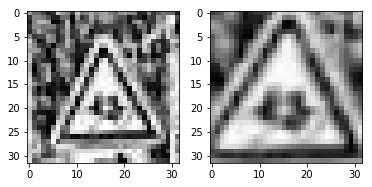

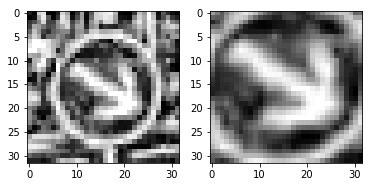

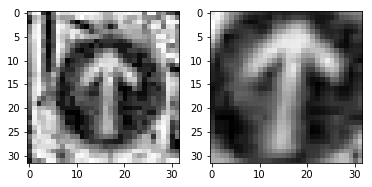

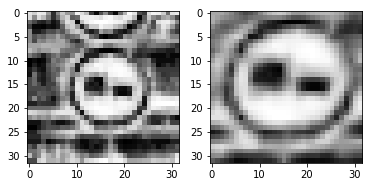

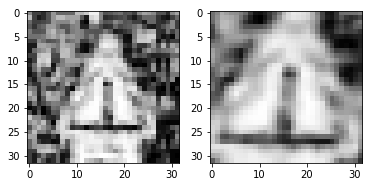

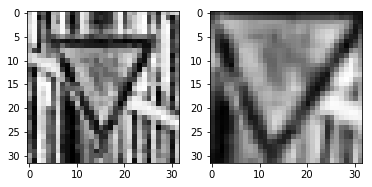

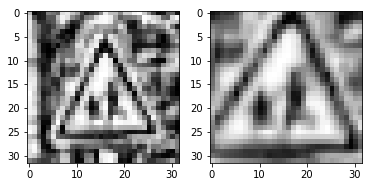

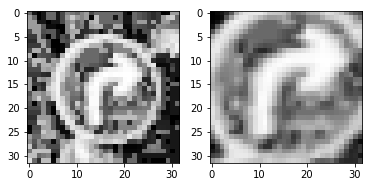

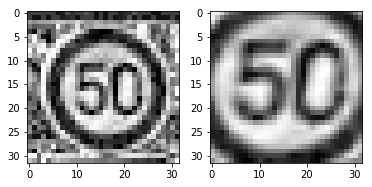

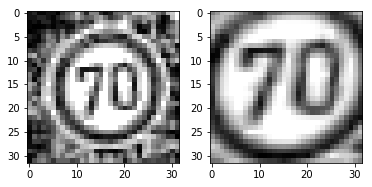

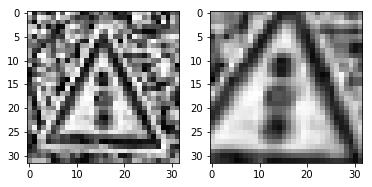

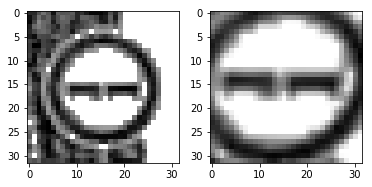

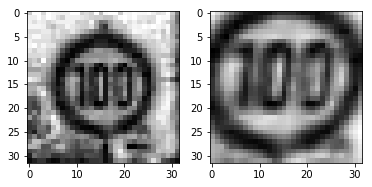

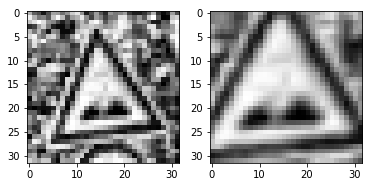

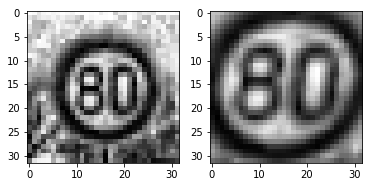

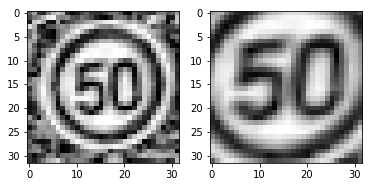

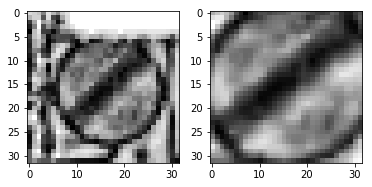

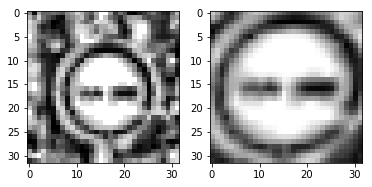

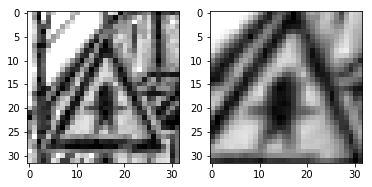

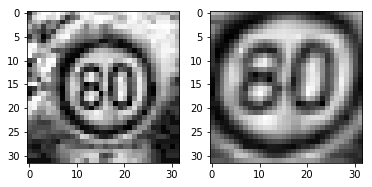

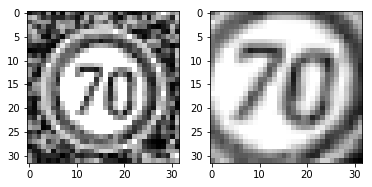

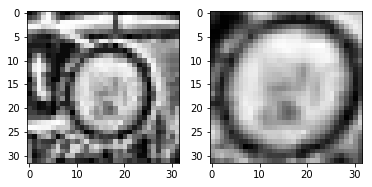

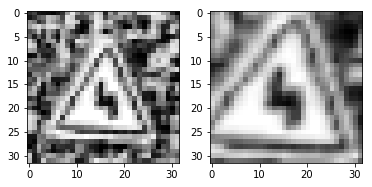

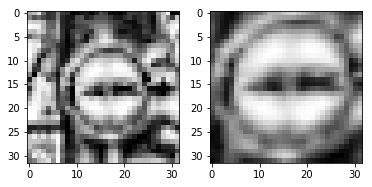

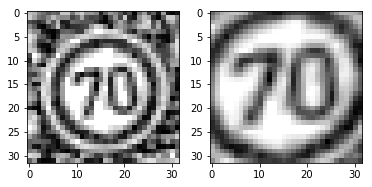

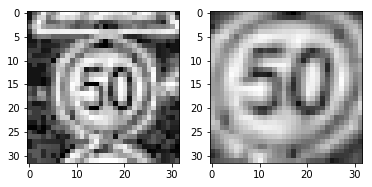

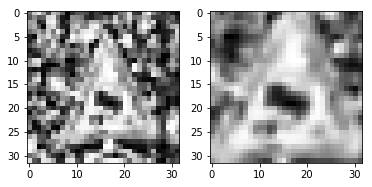

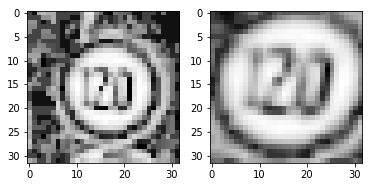

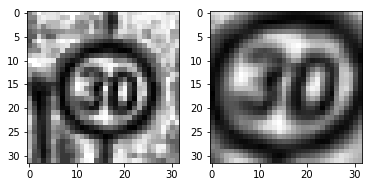

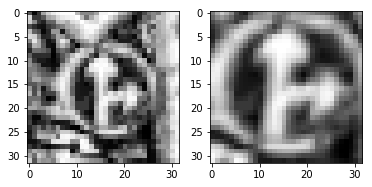

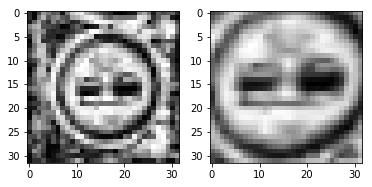

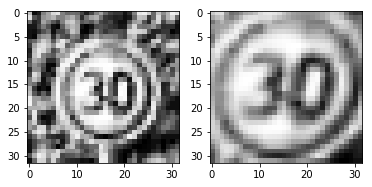

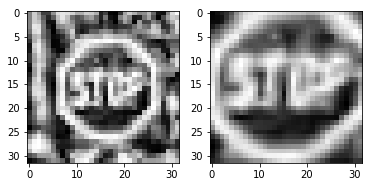

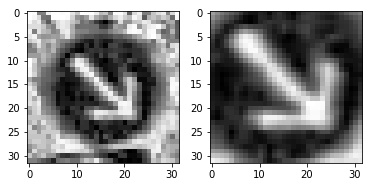

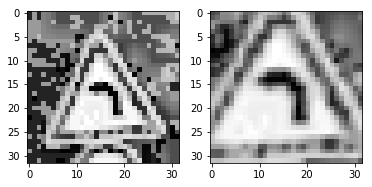

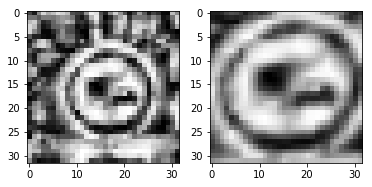

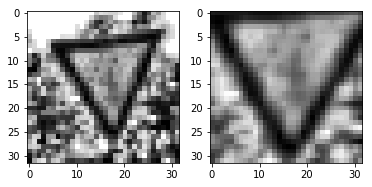

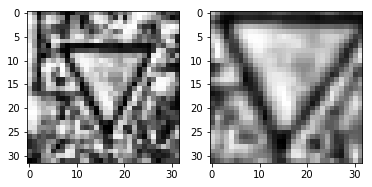

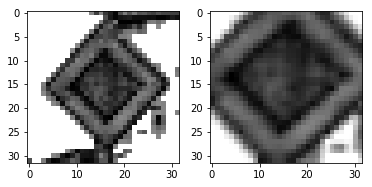

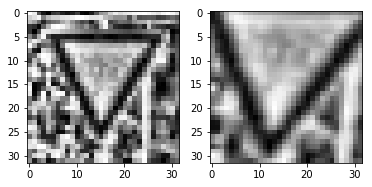

In [26]:
batch = X_val_stn
default = train_val_data['X_val']
idx = []

cols = 2
rows = 40
n_elements = cols*rows

for i in range(n_elements):
    idx.append(random.randint(0, len(X_val)))
    
for row in range(rows):
    plt.figure()
    for col in range(cols):
        ix = idx.pop()
        plt.subplot(1,2,1)
        plt.imshow(default[ix].reshape(32,32), cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(batch[ix].reshape(32,32), cmap='gray')

In [53]:
with tf.Graph().as_default():
    saver = tf.train.import_meta_graph('model/stn_idsia_model.ckpt.meta')
    with tf.Session() as sess:
        saver.restore(sess, "model/stn_idsia_model.ckpt")
        acc = 0
        for i, (x,y) in tqdm(enumerate(zip(X_val, y_val))):
            x = np.expand_dims(x, axis=0)
            feed = {x: x, dropout_conv: 1.0, dropout_fc1: 1.0, dropout_loc: 1.0}
            pred = sess.run([logits], feed)
            if pred.argmax() == y.argmax():
                print(int(pred[pred.argmax()]))
                acc+=1
        print(round(acc/len(X_val)*100, 2))

INFO:tensorflow:Restoring parameters from model/stn_idsia_model.ckpt


TypeError: unhashable type: 'numpy.ndarray'